# House Price Challenge
> - Wolfgang Moser wolfgang.moser@woodmark.de
> - Frank Ditsche frank.ditsche@woodmark.de
> - Simon Heeg simon.heeg@woodmark.de

Import necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

Load input data:

In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

Check data dimensions:

In [3]:
print("Number of features in training set: {}".format(train.shape[1]))
print("Number of training data entries: {}".format(train.shape[0]))
print("Number of test data entries: {}".format(test.shape[0]))

Number of features in training set: 81
Number of training data entries: 1460
Number of test data entries: 1459


Where is the ID / the training prices?

In [4]:
print("First column in both sets is: {}".format(train.columns[0]))
print("Last column in training set is: {}".format(train.columns[-1]))

First column in both sets is: Id
Last column in training set is: SalePrice


Make index column the actual data frame index:

In [5]:
train.set_index('Id', inplace=True)
test.set_index('Id', inplace=True)

Split off the price column from the training data:

In [6]:
train_price = train["SalePrice"]
train.drop("SalePrice", axis=1, inplace=True)

Check value ranges of features variables:

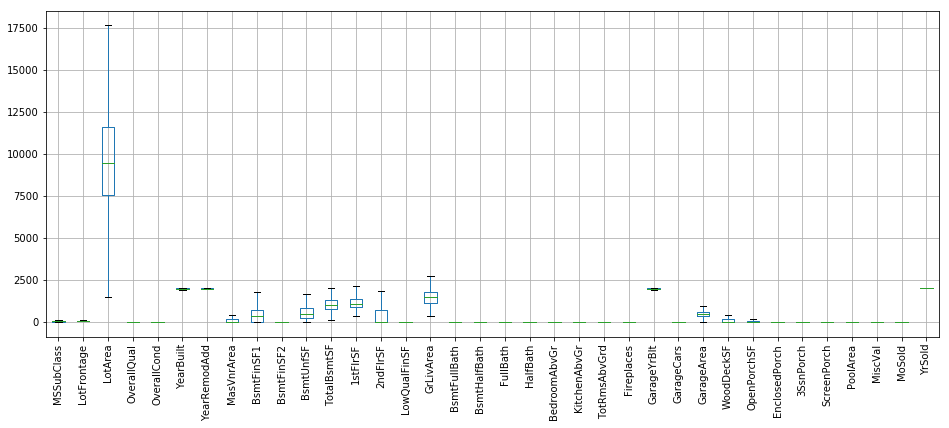

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
train.boxplot(showfliers=False, rot=90)
plt.show()

Deal with numerical features:

In [8]:
# extract locations of numerical features
num_feat = (train.dtypes != "object").as_matrix()
    
train_num = train.iloc[:, num_feat]
test_num = test.iloc[:, num_feat]

Check positivity and fill missing values with column means:

In [9]:
print("All numerical values in training set positive? {}"
      .format(not (train_num < 0).any().any()))
# fill missing values in training set with column means
train_num = train_num.fillna(train_num.mean())
train.iloc[:, num_feat] = train_num

print("All numerical values in test set positive? {}"
      .format(not (test_num < 0).any().any()))
# fill missing values in test set with TRAINING column means
test_num = test_num.fillna(train_num.mean())
test.iloc[:, num_feat] = test_num

All numerical values in training set positive? True
All numerical values in test set positive? True


Check skewness:

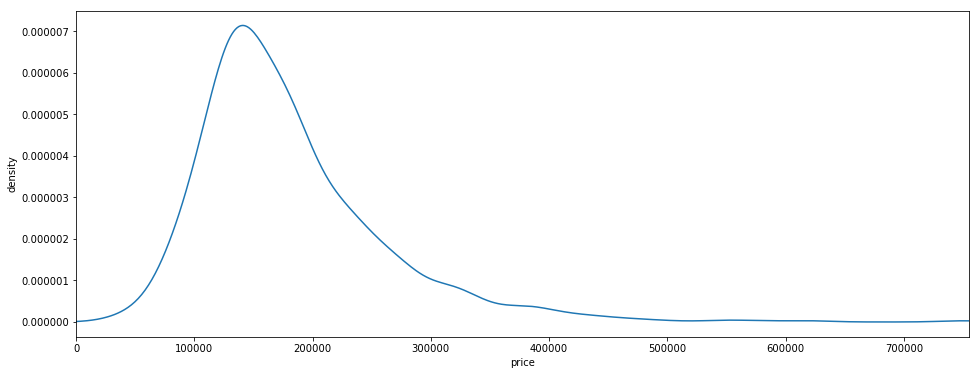

In [10]:
ax = train_price.plot.density()
ax.set_xlim([0,train_price.max()])
ax.set_xlabel("price")
ax.set_ylabel("density")
plt.show()

In [11]:
print("Numerical feature columns: {}".format(train.columns[num_feat]))
print("Skeweness of numerical training features: {}"
      .format(skew(train_num)))

Numerical feature columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
Skeweness of numerical training features: [  1.40621011   2.38249918  12.19514213   0.21672098   0.69235521
  -0.61283072  -0.5030445    2.67366126   1.6837709    4.25088802
   0.9193227    1.52268809   1.37534174   0.81219427   9.00208042
   1.36515595   0.59545404   4.09918567   0.03652398   0.67520283
   0.21157244   4.48378409   0.67564577   0.64889763  -0.66748815
  -0.3421969    0.1797

log(1+p) transform of skewed features:

In [12]:
skewed = (np.absolute(skew(train_num)) > 1)
train_num.iloc[:, skewed] = np.log1p(train_num.iloc[:, skewed])
test_num.iloc[:, skewed] = np.log1p(test_num.iloc[:, skewed])
train_price = np.log1p(train_price)

print("Skeweness of numerical training features after transformation: {}"
      .format(skew(train_num)))

Skeweness of numerical training features after transformation: [  2.48741218e-01  -8.91060059e-01  -1.37263272e-01   2.16720977e-01
   6.92355214e-01  -6.12830724e-01  -5.03044497e-01   4.80625684e-01
  -6.17774284e-01   2.52110019e+00   9.19322702e-01  -5.14937258e+00
   8.00317572e-02   8.12194273e-01   7.45264962e+00  -6.13394321e-03
   5.95454038e-01   3.92902155e+00   3.65239844e-02   6.75202835e-01
   2.11572442e-01   3.86543714e+00   6.75645767e-01   6.48897631e-01
  -6.67488146e-01  -3.42196895e-01   1.79795942e-01   1.53378802e-01
  -2.33732497e-02   2.11010418e+00   7.72702571e+00   3.14717122e+00
   1.43483416e+01   5.16538998e+00   2.11835060e-01   9.61695796e-02]


Normalize numerical features:

In [13]:
scaler = StandardScaler().fit(train_num)
train_num = scaler.transform(train_num)
test_num = scaler.transform(test_num)

Apply the transformed values to the orginial sets:

In [14]:
train.iloc[:, num_feat] = train_num
test.iloc[:, num_feat] = test_num

Transform categorical to numerical features:

In [15]:
train_test = pd.concat([train, test])
train_test = pd.get_dummies(train_test)
train_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.424462,-0.087206,-0.133270,0.651479,-0.517200,1.050994,0.878668,1.193074,0.779431,-0.355342,...,0,0,0,1,0,0,0,0,1,0
2,-1.125202,0.563711,0.113413,-0.071836,2.179628,0.156734,-0.429577,-0.815959,0.888257,-0.355342,...,0,0,0,1,0,0,0,0,1,0
3,0.424462,0.054079,0.420049,0.651479,-0.517200,0.984752,0.830215,1.121030,0.654803,-0.355342,...,0,0,0,1,0,0,0,0,1,0
4,0.645073,-0.337602,0.103317,0.651479,-0.517200,-1.863632,-0.720298,-0.815959,0.384539,-0.355342,...,0,0,0,1,1,0,0,0,0,0
5,0.424462,0.716916,0.878431,1.374795,-0.517200,0.951632,0.733308,1.412710,0.754400,-0.355342,...,0,0,0,1,0,0,0,0,1,0


Split sets again:

In [16]:
train = train_test.iloc[:train.shape[0], :]
test = train_test.iloc[train.shape[0]:, :]

## Finally start with machine learning:

First try: __Linear Regression__

In [17]:
lin_reg = linear_model.LinearRegression()
scores = cross_val_score(lin_reg, train, train_price,
                         cv=5, scoring='neg_mean_squared_error')
print("Mean of 5 CV sqrt MSE: {}".format(np.sqrt(-scores.mean())))

Mean of 5 CV sqrt MSE: 1896891255.094376


Second try: __Ridge Regression__

In [18]:
ridge = linear_model.Ridge(alpha=10.)
scores = cross_val_score(ridge, train, train_price,
                         cv=5, scoring='neg_mean_squared_error')
print("Mean of 5 CV sqrt MSE: {}".format(np.sqrt(-scores.mean())))

Mean of 5 CV sqrt MSE: 0.1279236278629444


Ridge Regression seems to work better!

In [19]:
ridge.fit(train, train_price)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Apply estimator to test set:

In [20]:
preds = ridge.predict(test)

Retransform predicted prices:

In [21]:
preds_price = np.expm1(preds)

Prepare format for submission and save as CSV:

In [22]:
test_results = pd.DataFrame({'SalePrice': preds_price,
                             'Id': test.index})
test_results.set_index('Id', inplace=True)

test_results.to_csv("output/test_results.csv")